##### 1. INSTALL AND IMPORT DEPENDENCIES

In [76]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time,json,uuid
import os
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Layer,Conv2D,MaxPooling2D,Input


##### 2 CREATE FOLDER STRUCTURE

In [2]:
# Setup paths

''' we will be using the siamese neural network which performs one shot 
recogonition, hence we will need the input images to be compared to some 
other images. We will represent the input images lookalike as positive and
it opposite will be negative and input image will be name anchor '''


PATHS = {
    'data': Path('data'),
    'positive_path': Path('data','positive'),
    'negative_path': Path('data','negative'),
    'anchor_path': Path('data','anchor'),
}

# create directories
for key in PATHS.keys():
    PATHS[key].mkdir(parents=True,exist_ok=True)

##### 3. UNTAR LABELLED FACES IN THE WILD DATASET

In [5]:
!tar -xf lfw.tgz

In [20]:
def traverse_directory(folder_path):
    for item in folder_path.iterdir():
        if item.is_file():
            shutil.copy(item,PATHS['negative_path'])
        if item.is_dir():
            traverse_directory(item)

traverse_directory(Path('lfw'))

##### 4. COLLECT POSITIVES AND ANCHORS

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    if not ret:
        break

    frame = frame[120:120+250,200:200+250,:]

    if cv2.waitKey(1) & 0xFF == ord('a'):
        image_filepath = f"{Path(PATHS['anchor_path'],str(uuid.uuid1()) + '.jpg')}"
        cv2.imwrite(image_filepath,frame)

    if cv2.waitKey(1) & 0xFF == ord('p'):
        image_filepath = f"{Path(PATHS['positive_path'],str(uuid.uuid1()) + '.jpg')}"
        cv2.imwrite(image_filepath,frame)


    cv2.imshow('Image Collection',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

##### 5. PROPROCESS IMAGES( BY CREATING POSITIVE AND NEGATIVE SAMPLES)

In [91]:
def create_dataset(pattern):
    datasets = tf.data.Dataset.list_files(pattern,shuffle=False).take(300)
    datasets = datasets.map(read_file)
    return datasets

def read_file(x):
    img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img,(100,100))
    img = img / 255
    return img

def labelled_dataset(data1,data2,label):
    if label == 0:
        lab_dataset = tf.data.Dataset.zip((data1,data2,tf.data.Dataset.from_tensor_slices(tf.zeros(len(data1)))))
    if label == 1:
        lab_dataset = tf.data.Dataset.zip((data1,data2,tf.data.Dataset.from_tensor_slices(tf.ones(len(data1)))))
    return lab_dataset

anchor = create_dataset(str(Path(PATHS['anchor_path'],'*.jpg')))
positive = create_dataset(str(Path(PATHS['positive_path'],'*.jpg')))
negative = create_dataset(str(Path(PATHS['negative_path'],'*.jpg')))

In [92]:
positive_label = labelled_dataset(anchor,positive,1)
negative_label = labelled_dataset(anchor,negative,0)

In [93]:
all_dataset = positive_label.concatenate(negative_label)
all_dataset = all_dataset.cache()
all_dataset = all_dataset.shuffle(buffer_size=1024)

In [81]:
a = all_dataset.as_numpy_iterator()

0.0


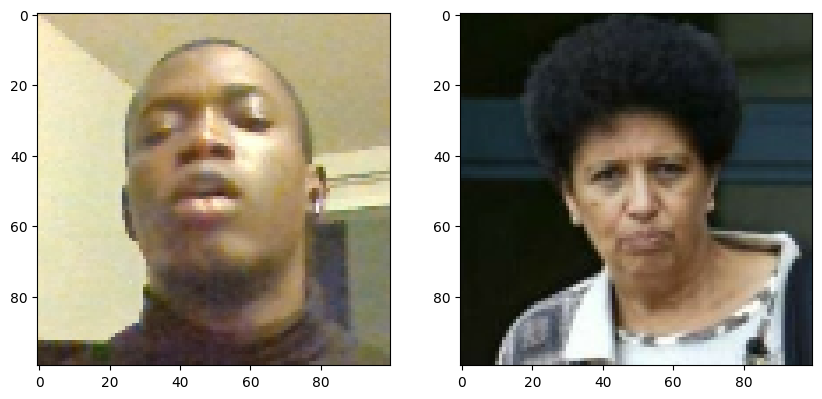

In [82]:
def plot_dataset_image(image):
    fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i in range(2):
        axes[i].imshow(image[i])
    print(image[2])

plot_dataset_image(a.next())

##### 6. SPLIT TO TRAIN AND TEST PARTITION

In [99]:
length_of_dataset = len(all_dataset)
length_of_dataset

600

In [110]:
train_dataset = all_dataset.take(round(len(all_dataset) * .7))
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.prefetch(8)

test_dataset = all_dataset.skip(round(len(all_dataset) * .7))
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)


##### 6. MODEL ENGINEERING

###### 6.1 BUILD AN EMBEDDING LAYER

In [120]:
def make_embedded():
    inp = Input(shape=(100,100,3))

    # First block
    conv1 = Conv2D(64,activation='relu',kernel_size=(10,10))(inp)
    maxpool1 = MaxPooling2D(64,(2,2),padding='same')(conv1)

    # Second block
    conv2 = Conv2D(128,activation='relu',kernel_size=(7,7))(maxpool1)
    maxpool2 = MaxPooling2D(64,(2,2),padding='same')(conv2)

    # Third block
    conv3 = Conv2D(128,activation='relu',kernel_size=(4,4))(maxpool2)
    maxpool3 = MaxPooling2D(64,(2,2),padding='same')(conv3)

    # Fourth block
    conv4 = Conv2D(256,activation='relu',kernel_size=(4,4))(maxpool3)
    flatten1 = Flatten()(conv4)

    # Fully connected layer 1
    dense1 = Dense(activation='sigmoid')(flatten1)
    dense2 = Dense(activaton='sigmoid')(dense1)
    return Model(input=inp,output=dense2)

In [119]:
inp = Input(shape=(100,100,3))

conv1 = Conv2D(64,activation='relu',kernel_size=(10,10))(inp)

maxpool1 = MaxPooling2D(64,(2,2),padding='same')(conv1)
maxpool1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>